In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape
from keras.callbacks import EarlyStopping
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

2023-04-05 16:37:49.040810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def log_price(list_stock_prices):
        return np.log(list_stock_prices)
    
def realized_volatility(data):
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

def load_data(path):
    data = pd.read_csv(path)
    data.columns = ['scrape_time','lastUpdateId','bp1','bs1','bp2','bs2',
                    'bp3','bs3','bp4','bs4','bp5','bs5','bp6','bs6','bp7',
                    'bs7','bp8','bs8','bp9','bs9','bp10','bs10','bp11',
                    'bs11','bp12','bs12','bp13','bs13','bp14','bs14',
                    'bp15','bs15','bp16','bs16','bp17','bs17','bp18',
                    'bs18','bp19','bs19','bp20','bs20','ap1','as1','ap2',
                    'as2','ap3','as3','ap4','as4','ap5','as5','ap6','as6',
                    'ap7','as7','ap8','as8','ap9','as9','ap10','as10','ap11',
                    'as11','ap12','as12','ap13','as13','ap14','as14','ap15',
                    'as15','ap16','as16','ap17','as17','ap18','as18','ap19',
                    'as19','ap20','as20']
    return data

In [3]:
def data_preprocess(data):
    data['WAP'] = (data['bp1']*data['bs1']
               +data['bp2']*data['bs2']
               +data['ap1']*data['as1']
               +data['ap2']*data['as2'])/(data['bs1']+
                                         data['bs2']+
                                         data['as1']+
                                         data['as2'])
    data['spread'] = ((data['ap1']/data['bp1']) - 1)
    data.insert(0, 'log_price', log_price(data['WAP']))
    data['log_returns'] = data.log_price.diff()
    data['realized_volatility'] = realized_volatility(data)
    data['volatility_t+1'] = data['realized_volatility'].shift(-1)
    imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice
    imputer.fit(data[['volatility_t+1']]) # Call the "fit" method on the object
    data['volatility_t+1'] = imputer.transform(data[['volatility_t+1']])
    stime = pd.to_datetime(data['scrape_time'])
    data['scrape_time'] = (stime - stime.shift(1)).dt.total_seconds()
    data['bid depth'] = data[['bs1', 'bs2', 'bs3','bs4', 'bs5', 'bs6','bs7', 'bs8', 'bs9','bs10',
                         'bs11', 'bs12', 'bs13','bs14', 'bs15', 'bs16','bs17', 'bs18', 'bs19','bs20']].sum(axis=1)
    data['ask depth'] = data[['as1', 'as2', 'as3','as4', 'as5', 'as6','as7', 'as8', 'as9','as10',
                         'as11', 'as12', 'as13','as14', 'as15', 'as16','as17', 'as18', 'as19','as20']].sum(axis=1)
    data['FDOFI'] = (data['bid depth']-data['ask depth'])/(data['bid depth']+data['ask depth'])
    return data[2:-1]

def generate_X_Y(data, look_back=24, look_forward=4):
    # X = data[['WAP', 'spread', 'log_returns', 'bid depth', 'ask depth', 'FDOFI', 'log_price', 'scrape_time']]
    X = data[['WAP', 'spread', 'FDOFI', 'log_price', 'scrape_time']]
    # X = data[['WAP', 'spread', 'log_price', 'scrape_time']]
    y = np.expand_dims(data['volatility_t+1'].values, 1)
    scaler = MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)
    output_X, output_Y =[], []
    for i in range(len(X_scaled)-look_back-look_forward):
        d=i+look_back
        e=d+look_forward
        output_X.append(np.hstack((X_scaled[i:d],y[i:d])))
        output_Y.append(np.hstack((X_scaled[d:e],y[d:e])))
    return np.array(output_X), np.array(output_Y)

In [4]:
data = load_data('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data_0401(6hrs).csv')
data_p = data_preprocess(data)
X,y = generate_X_Y(data_p, look_forward=8)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=3600, test_size=3000)

In [5]:
def model_c_c_f(input_x, input_y):
    look = {'back': input_x.shape[1], 'forward': input_y.shape[1]}
    model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(look['back'], input_x.shape[2])),
    Dropout(0.2),
    Dense(look['forward']*input_y.shape[2]),
    Reshape([look['forward'], input_y.shape[2]])
    ])
    model.compile(loss='mse', optimizer=Adam(0.0008), metrics=['accuracy'])
    history = model.fit(input_x, input_y, epochs=500, batch_size=16, shuffle=True,
                    validation_split=0.4,
                    callbacks =
                    [EarlyStopping(patience=50, verbose=1, restore_best_weights=True)])
    return model, look, history

def p5760(model, dataf, look):
    # flist = ['WAP', 'spread', 'log_price', 'scrape_time']
    flist = ['WAP', 'spread', 'FDOFI', 'log_price', 'scrape_time']
    features = dataf[flist]
    scaled_data = np.hstack((MinMaxScaler().fit_transform(features), np.expand_dims(dataf['volatility_t+1'].values, 1)))
    newest_data = scaled_data[-look['back']:,:].reshape([1,look['back'],len(flist)+1])
    prediction = model.predict(newest_data)
    # print(prediction.shape)
    predictions = [*prediction[0]]
    while len(predictions) < 5760:
        newest_data = np.hstack((newest_data, prediction))[:,-look['back']:,:]
        # print(newest_data.shape)
        prediction = model.predict(newest_data)
        # print(prediction.shape)
        for p in prediction[0]:
            predictions.append(p)
    return np.array(predictions)

In [6]:
model, look, history = model_c_c_f(X_train, y_train)

2023-04-05 16:37:55.056612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
135/135 [==============================] - 3s 9ms/step - loss: 0.0612 - accuracy: 0.2898 - val_loss: 0.0112 - val_accuracy: 0.2594
Epoch 2/500
135/135 [==============================] - 1s 6ms/step - loss: 0.0173 - accuracy: 0.4203 - val_loss: 0.0084 - val_accuracy: 0.4249
Epoch 3/500
135/135 [==============================] - 1s 6ms/step - loss: 0.0134 - accuracy: 0.4856 - val_loss: 0.0079 - val_accuracy: 0.4215
Epoch 4/500
135/135 [==============================] - 1s 6ms/step - loss: 0.0118 - accuracy: 0.4994 - val_loss: 0.0076 - val_accuracy: 0.4521
Epoch 5/500
135/135 [==============================] - 1s 6ms/step - loss: 0.0108 - accuracy: 0.5019 - val_loss: 0.0076 - val_accuracy: 0.5655
Epoch 6/500
135/135 [==============================] - 1s 6ms/step - loss: 0.0102 - accuracy: 0.5138 - val_loss: 0.0069 - val_accuracy: 0.4257
Epoch 7/500
135/135 [==============================] - 1s 6ms/step - loss: 0.0094 - accuracy: 0.5160 - val_loss: 0.0062 - val_accuracy: 0.4905

In [7]:
model.evaluate(X_test, y_test),model.evaluate(X, y)

286/286 [==============================] - 1s 2ms/step - loss: 0.0027 - accuracy: 0.8703


([0.002707442967221141, 0.8712916374206543],
 [0.002666416810825467, 0.8702943921089172])

286/286 [==============================] - 1s 2ms/step


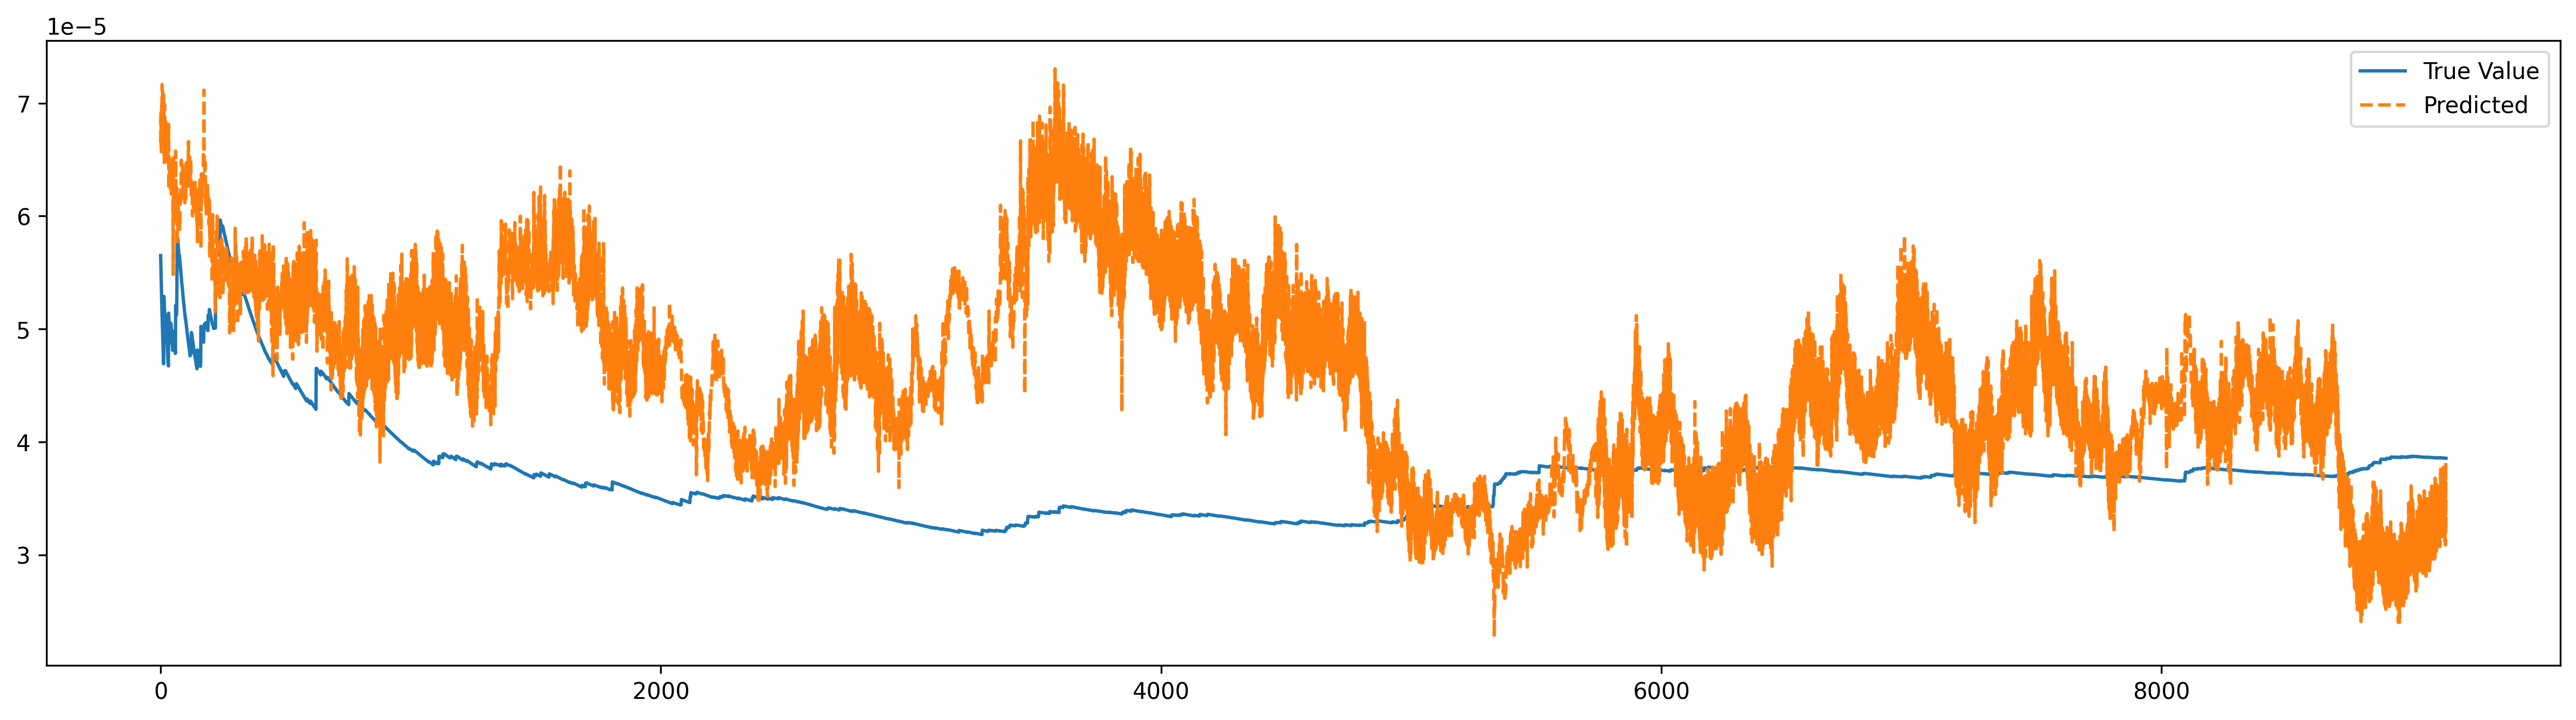

In [8]:
pred = model.predict(X)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y[:,0,-1],label='True Value')
plt.plot(pred[:,0,-1],linestyle='--', label = 'Predicted')
# plt.ylim(max(y_test[:,0,-1]), min(y_test[:,0,-1]))
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

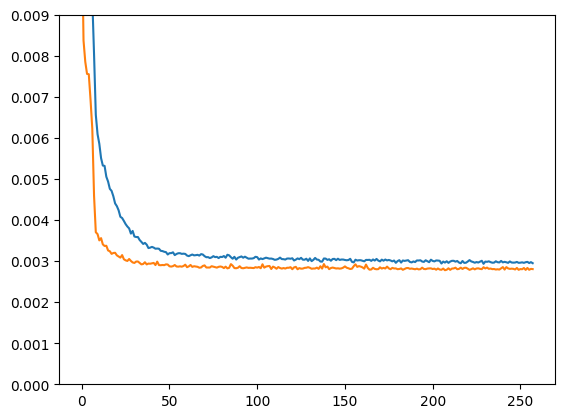

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 0.009)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

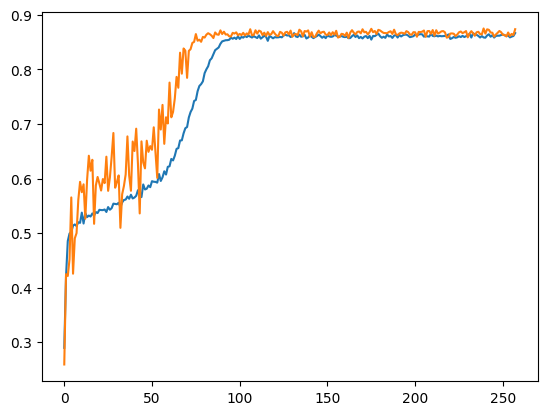

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show

In [12]:
pred5760 = p5760(model, data_p, look)
pred5760.shape

1/1 [==============================] - 0s 24ms/step


(5760, 6)

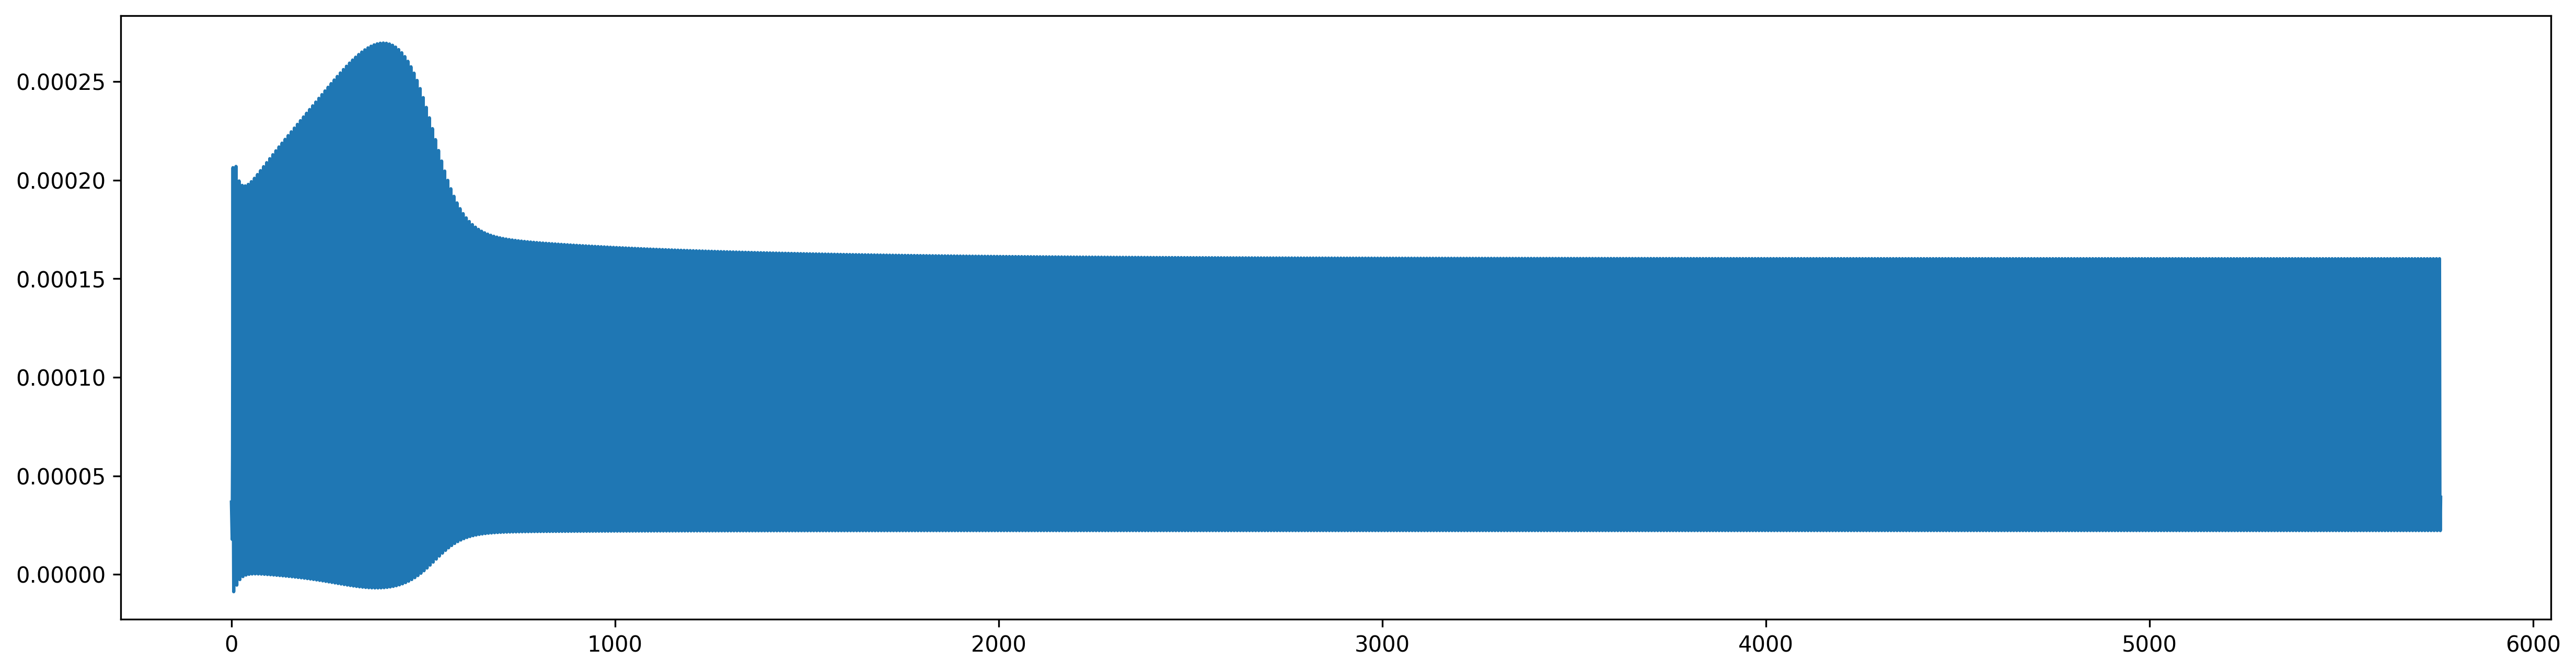

In [13]:
plt.figure(figsize=(20,5),dpi=300)
plt.plot(pred5760[:,-1])
plt.show()

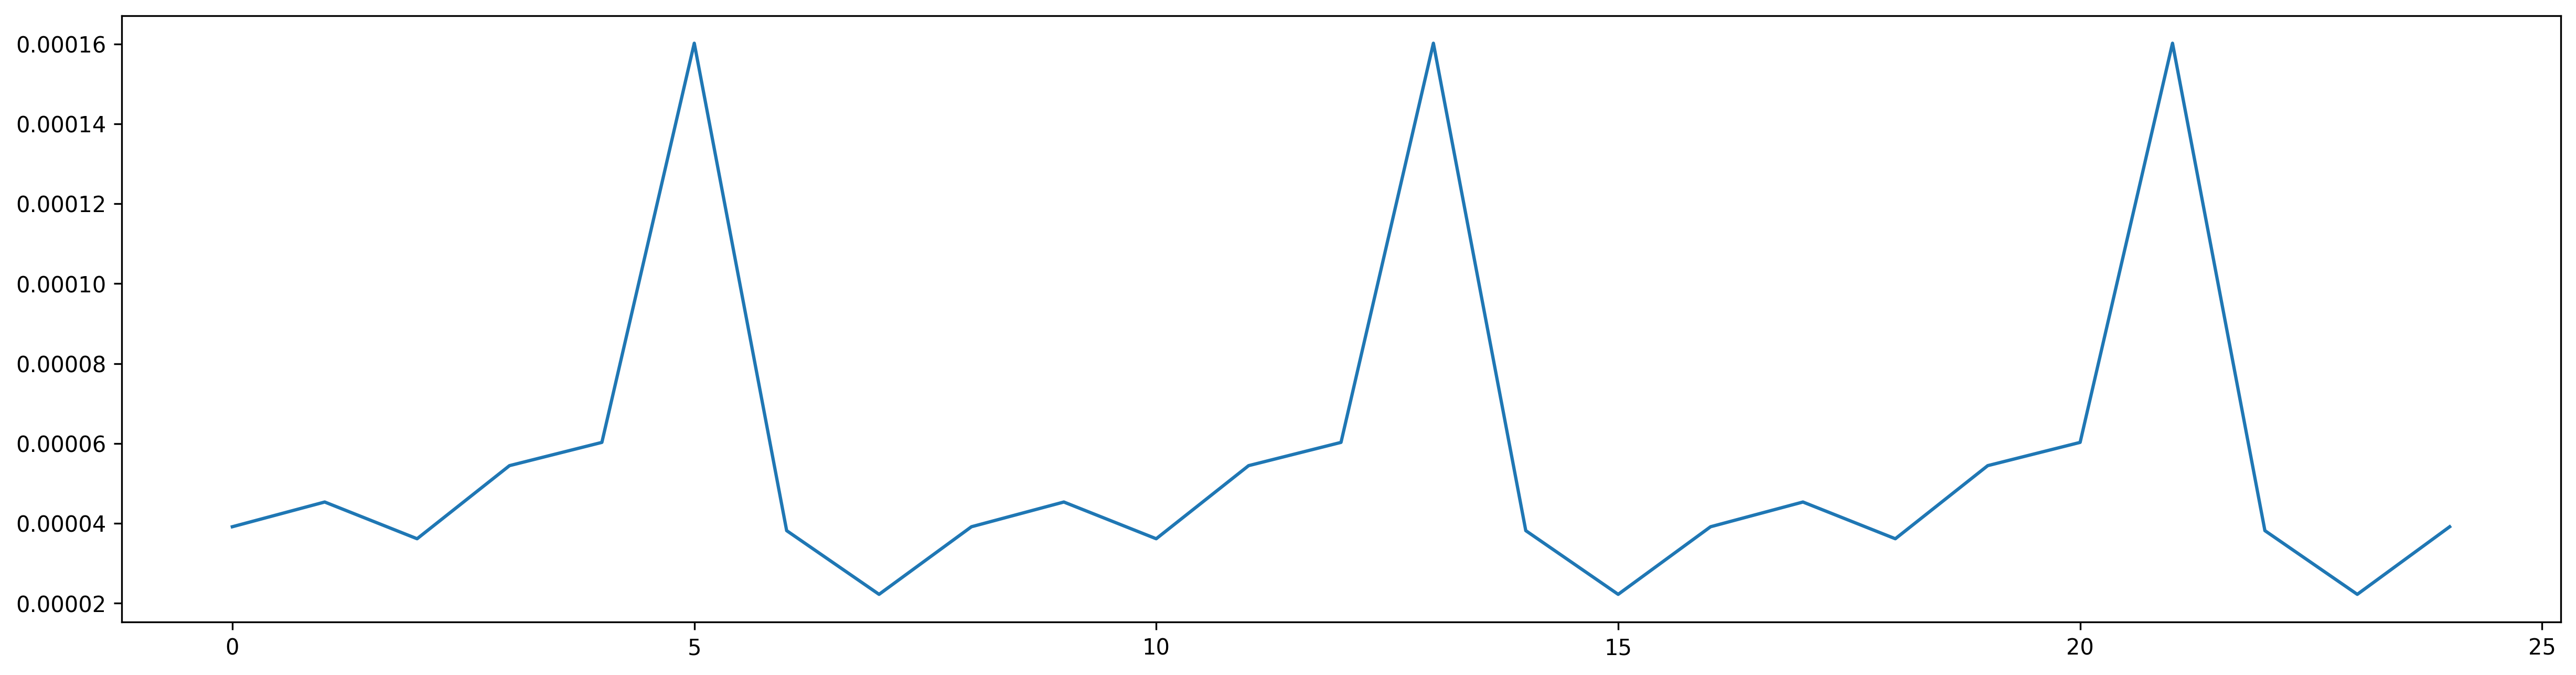

In [14]:
plt.figure(figsize=(20,5),dpi=300)
plt.plot(pred5760[-25:,-1])
plt.show()